In [1]:
import os
import sys
import math
import logging
from pathlib import Path
import polars as pl
import plotly.express as px
import dash
import dash_bootstrap_components as dbc
import numpy as np
import scipy as sp
import sklearn
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", '{:.3f}'.format)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import polars.selectors as cs
import seaborn as sns
sns.set_context("poster")
sns.set_theme(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
import matplotlib.pyplot as plt
import plotly.express as px
%load_ext autoreload
%autoreload 2
from sklearn.decomposition import PCA    
from tdt.data.obb_data import get_treasury_yields, add_bond_metrics_to_obb_data
from tdt.data.analytics import transform_pca
import statsmodels.api as sm

In [2]:
data = add_bond_metrics_to_obb_data(get_treasury_yields('2019-01-01','2025-01-01'))


In [22]:
rates=data.with_columns(pl.col('par_yield').mul(100).alias('rate'))\
.pivot(on='term',index='dt',values='rate').to_pandas().set_index('dt')
print(rates.tail(5))
rates = rates.resample('W').last()

               2     5     7    10    20    30
dt                                            
2024-12-23 4.300 4.440 4.520 4.590 4.850 4.780
2024-12-26 4.300 4.420 4.490 4.580 4.830 4.760
2024-12-27 4.310 4.450 4.530 4.620 4.890 4.820
2024-12-30 4.240 4.370 4.460 4.550 4.840 4.770
2024-12-31 4.250 4.380 4.480 4.580 4.860 4.780


In [4]:
diff_rates = rates.diff().dropna()
diff_rates_std = diff_rates-diff_rates.mean()

In [5]:
pca = PCA().fit(diff_rates_std)

In [25]:
pd.Series(pca.explained_variance_)

0   0.088
1   0.009
2   0.001
3   0.000
4   0.000
5   0.000
dtype: float32

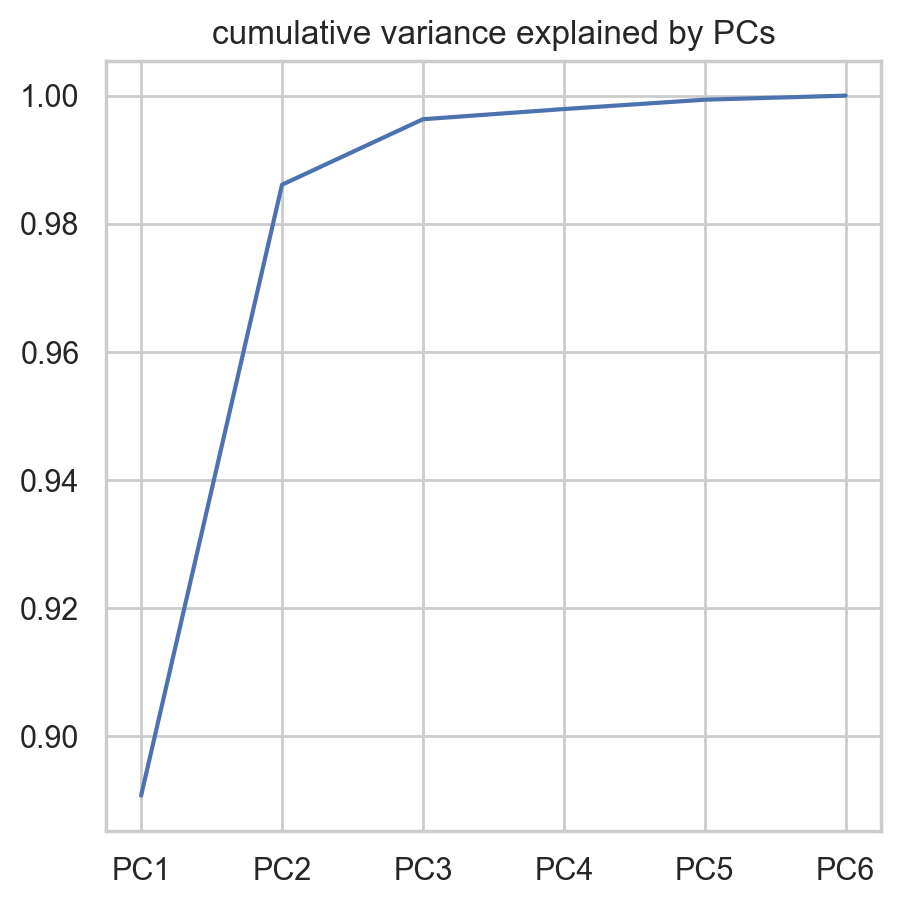

In [36]:
pd.Series(pca.explained_variance_ratio_).cumsum().rename({x-1:f'PC{x}' for x in range(1,7)}).plot(title='cumulative variance explained by PCs',figsize=(5,5));

In [45]:
pca = PCA(n_components=3).fit(diff_rates_std)
pcs= pd.DataFrame(pca.transform(diff_rates_std),columns=['level','slope','curve'],index = diff_rates_std.index)

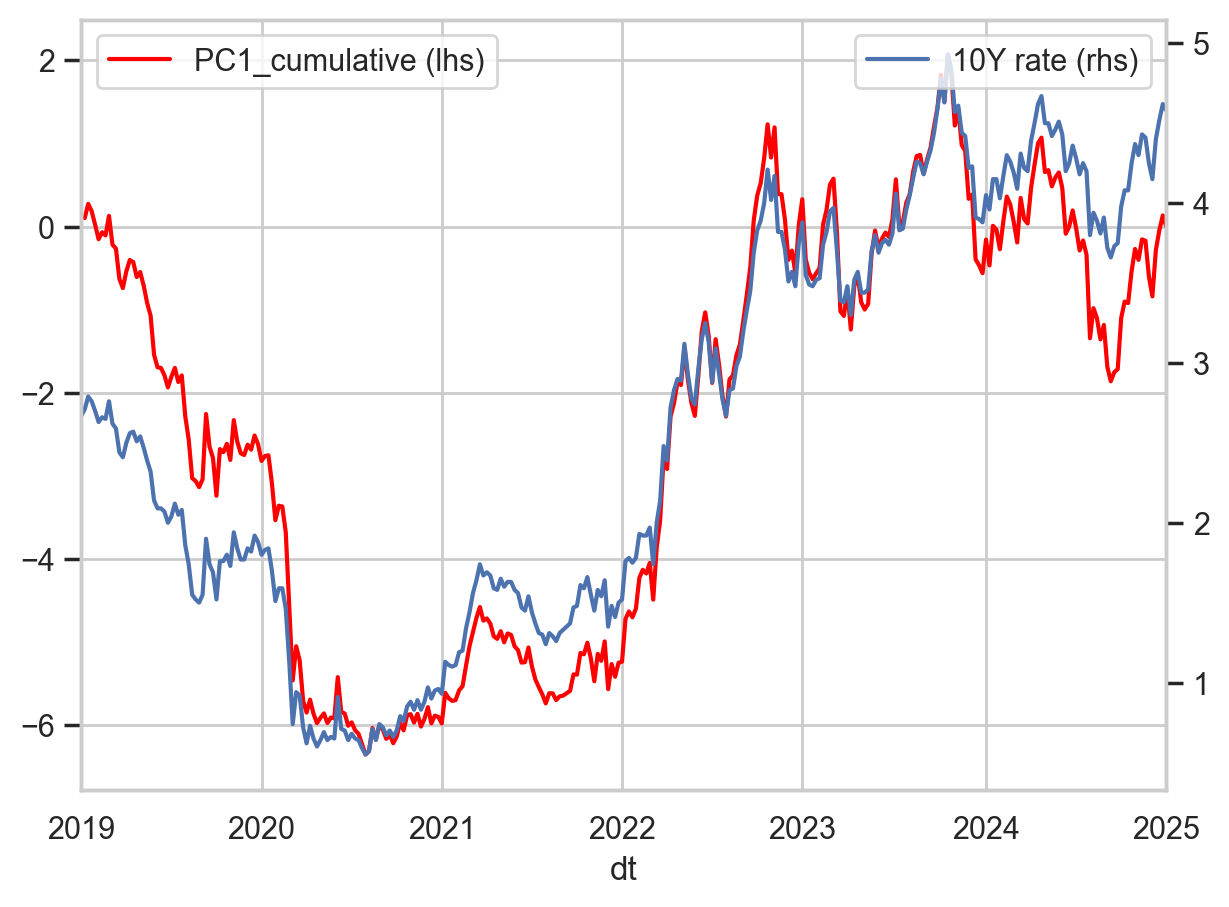

In [60]:
ax=pcs.cumsum()['level'].plot(figsize=(7,5),color='red')
ax.legend(labels=['PC1_cumulative (lhs)'],loc='upper left',)
ax2=ax.twinx()
rates['10'].plot(ax=ax2)
ax2.legend(labels=['10Y rate (rhs)'],loc='upper right')
ax2.grid(False)

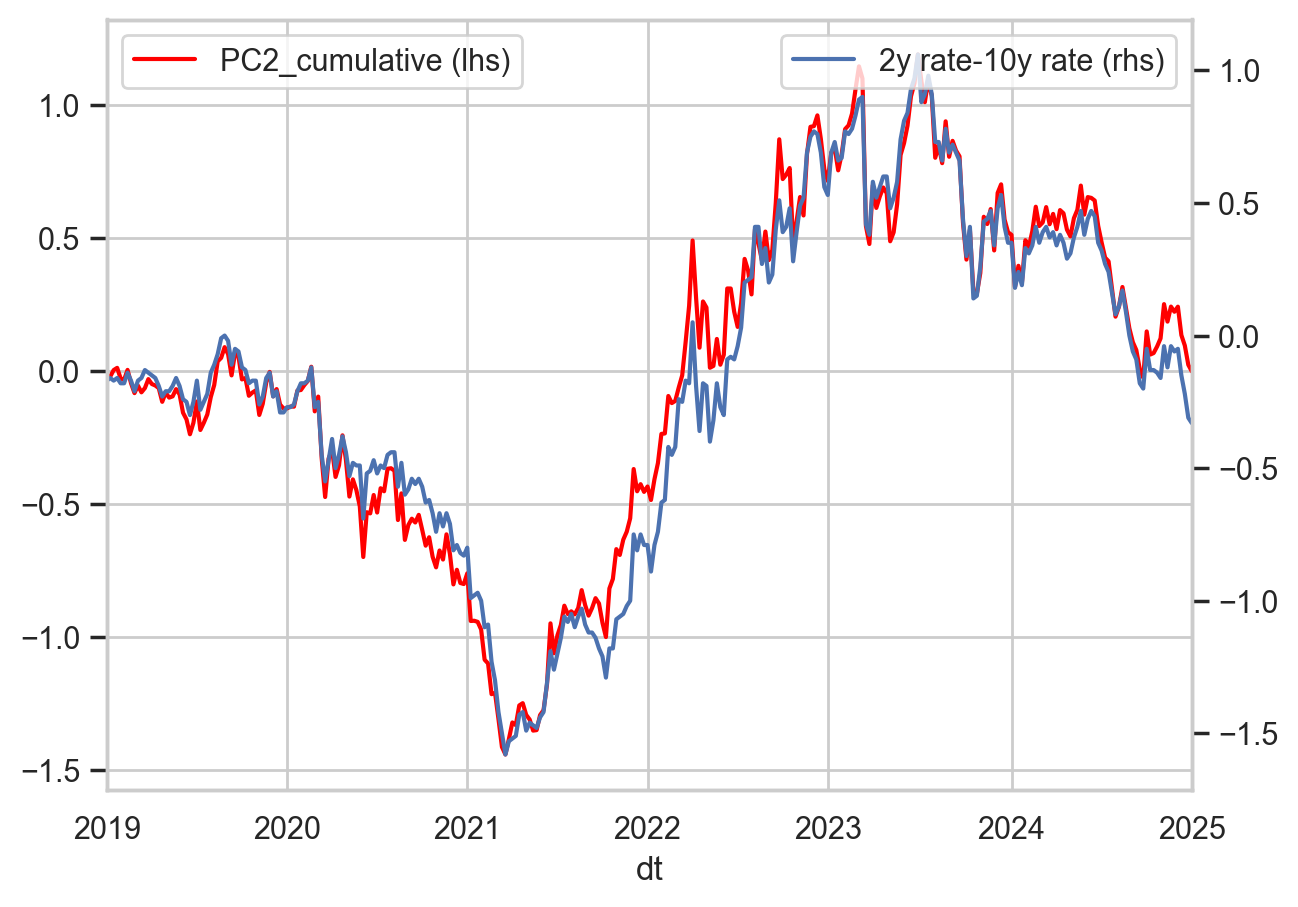

In [66]:
ax=pcs.cumsum()['slope'].plot(figsize=(7,5),color='red')
ax.legend(labels=['PC2_cumulative (lhs)'],loc='upper left',)
ax2=ax.twinx()
(rates['2']-rates['10']).plot(ax=ax2)
ax2.legend(labels=['2y rate-10y rate (rhs)'],loc='upper right')
ax2.grid(False)

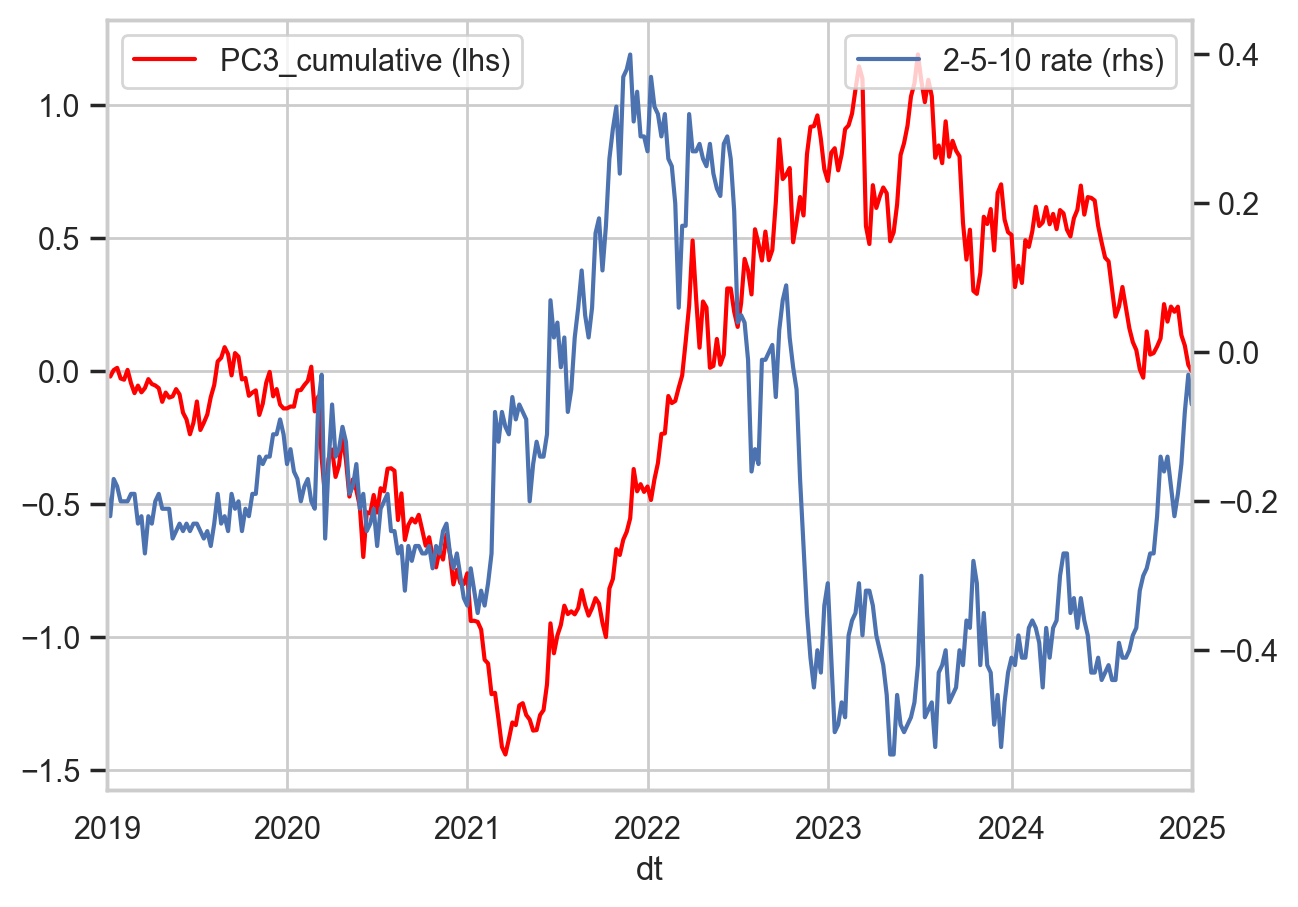

In [73]:
ax=pcs.cumsum()['slope'].plot(figsize=(7,5),color='red')
ax.legend(labels=['PC3_cumulative (lhs)'],loc='upper left',)
ax2=ax.twinx()
(2*rates['5']-(rates['2']+rates['10'])).plot(ax=ax2)
ax2.legend(labels=['2-5-10 rate (rhs)'],loc='upper right')
ax2.grid(False)

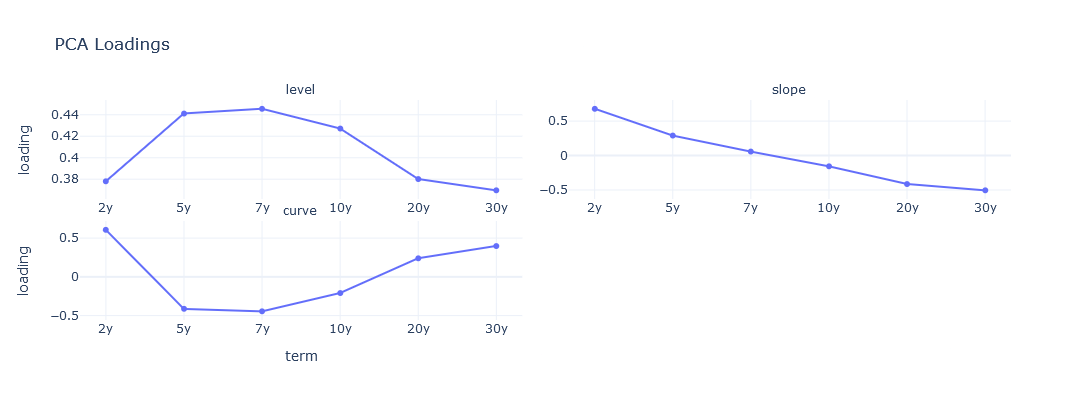

In [78]:
exposures=pd.DataFrame((pca.components_),index=['level','slope','curve']).rename(columns={k:v+'y' for k, v in enumerate(diff_rates_std.columns)}).reset_index()
fig=px.line(exposures.melt(id_vars='index',value_name='loading',var_name='term'),x='term',y='loading',
            facet_col='index',
            facet_col_wrap=2,
            facet_row_spacing=0.1,
            facet_col_spacing=0.05,
            title='PCA Loadings',
            markers=True)
fig.update_yaxes(matches=None,showticklabels=True)
fig.update_xaxes(matches=None,showticklabels=True)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(
        title=f"PCA Loadings",
        height=400, width=900,
        template='plotly_white',
        showlegend=False
    )